In [ ]:
df = spark.read\
.options(header='True', inferSchema='True', delimiter=',')\
.csv('data/DataSample.csv')


In [33]:
from math import radians, cos, sin, asin, sqrt, pi
import pandas as pd

from pyspark.sql import SparkSession
import pyspark.sql.functions as f


In [2]:
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def find_nearest(lat, long):
    distances = poi.apply(
        lambda row: dist(lat, long, row['Latitude'], row['Longitude']), 
        axis=1)
    
    temp = poi.loc[distances.idxmin()]
    
    temp['distancekm'] = distances.min()
 
    return  temp[['POIID','distancekm']]

(22025, 7)

In [4]:
dfp = dfp.rename(columns={' TimeSt':'TimeSt','_ID':'ID'})

In [5]:
dfp = dfp.drop_duplicates(subset=['TimeSt', 'Latitude', 'Longitude'],
                          keep=False)


(17973, 7)

In [6]:
# POI1 and POI2 refer to same location

poi = poi.rename(columns={' Latitude':'Latitude'})
poi = poi.drop_duplicates(subset=['Latitude','Longitude'])
poi.head()

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [7]:
dft = dfp.apply(lambda row: find_nearest(row['Latitude'], row['Longitude']), 
    axis=1)

dft.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,POIID,distancekm
0,POI3,593.413441
1,POI3,677.309655
2,POI3,569.647737
3,POI3,634.733996
4,POI3,634.733996


In [8]:
dfp = dfp.join(dft)

In [9]:
dfp.head()

,ID,TimeSt,Country,Province,City,Latitude,Longitude,POIID,distancekm
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3,593.413441
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3,677.309655
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3,569.647737
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3,634.733996
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3,634.733996


In [10]:
dfp.groupby('POIID').agg({'distancekm':['mean','std']})

distancekm             
             mean          std
POIID                         
POI1   300.714748   388.273385
POI3   451.651149   223.631742
POI4   514.997172  1506.889971

In [37]:
import matplotlib.pyplot as plt



In [67]:
circle = pd.merge(poi, 
                  dfp.groupby('POIID').agg({'distancekm':'max', 
                                            'ID':'count'}).reset_index().rename(columns={'distancekm':'radius',
                                                                                         'ID':'count'}), 
                  on='POIID')

circle['density'] = circle['count']/(pi*circle['radius']**2)
circle.head()

,POIID,Latitude,Longitude,radius,count,density
0,POI1,53.546167,-113.485734,11531.820832,8749,0.000021
1,POI3,45.521629,-73.566024,1474.580962,8802,0.001289
2,POI4,45.224830,-63.232729,9349.572770,422,0.000002


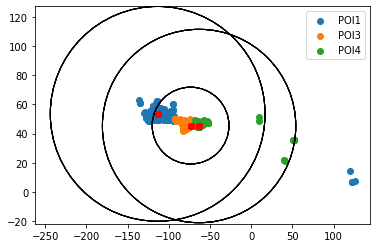

In [95]:
fig, ax = plt.subplots()

for name, group in dfp.groupby('POIID'):
    plt.scatter(x = group['Longitude'],
                y = group['Latitude'], 
                label = name)
    
for row in circle:
    plt.scatter(x = circle['Longitude'],
               y = circle['Latitude'],
               s = circle['radius']*4,
               facecolors= 'none',
               edgecolors= 'black')
    
for row in circle:
    plt.scatter(x = circle['Longitude'],
               y = circle['Latitude'],
               color = 'red')
    

plt.legend()
plt.show()